In [1]:
# ViTPose Keypoint Detection - Custom Dataset Training (Colab + Hugging Face)
# ------------------
!pip install -q transformers datasets torchvision pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.5 MB/s eta 0:00:00


In [2]:
from huggingface_hub import login
from google.colab import userdata
token = userdata.get('Nyi_token')
login(token=token)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face


In [ ]:
import torch
import requests
import numpy as np

from PIL import Image

from transformers import (
    AutoProcessor,
    RTDetrForObjectDetection,
    VitPoseForPoseEstimation,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

image_path = "datasets/excavators/Male-Posing.jpg"
image = Image.open(image_path).convert("RGB")

# ------------------------------------------------------------------------
# Stage 1. Detect humans on the image
# ------------------------------------------------------------------------

# You can choose detector by your choice
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]  # take first image results

# Human label refers 0 index in COCO dataset
person_boxes = result["boxes"][result["labels"] == 0]
person_boxes = person_boxes.cpu().numpy()

# Convert boxes from VOC (x1, y1, x2, y2) to COCO (x1, y1, w, h) format
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-base")
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-plus-base", device_map=device)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)

# This is MOE architecture, we should specify dataset indexes for each image in range 0..5
inputs["dataset_index"] = torch.tensor([0], device=device)

with torch.no_grad():
    outputs = model(**inputs)

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes], threshold=0.1)
image_pose_result = pose_results[0]  # results for first image

for i, person_pose in enumerate(image_pose_result):
    print(f"Person #{i}")
    for keypoint, label, score in zip(
        person_pose["keypoints"], person_pose["labels"], person_pose["scores"]
    ):
        keypoint_name = model.config.id2label[label.item()]
        x, y = keypoint
        print(f" - {keypoint_name}: x={x.item():.2f}, y={y.item():.2f}, score={score.item():.2f}")

Person #0
 - Nose: x=307.29, y=393.84, score=0.97
 - L_Eye: x=312.74, y=388.10, score=0.97
 - R_Eye: x=302.49, y=389.14, score=0.99
 - L_Ear: x=323.49, y=391.92, score=0.98
 - R_Ear: x=298.31, y=393.78, score=0.93
 - L_Shoulder: x=338.57, y=429.32, score=0.95
 - R_Shoulder: x=285.97, y=427.10, score=0.97
 - L_Elbow: x=355.11, y=471.02, score=0.98
 - R_Elbow: x=273.32, y=464.68, score=0.94
 - L_Wrist: x=340.87, y=500.96, score=0.96
 - R_Wrist: x=275.89, y=495.16, score=0.92
 - L_Hip: x=320.81, y=510.48, score=0.86
 - R_Hip: x=288.21, y=508.70, score=0.85
 - L_Knee: x=316.90, y=579.03, score=0.92
 - R_Knee: x=273.74, y=576.07, score=0.91
 - L_Ankle: x=309.58, y=641.32, score=0.94
 - R_Ankle: x=268.48, y=646.10, score=0.95
Person #1
 - Nose: x=487.28, y=395.60, score=0.98
 - L_Eye: x=492.10, y=389.53, score=0.98
 - R_Eye: x=482.00, y=390.78, score=0.99
 - L_Ear: x=502.28, y=391.14, score=0.98
 - R_Ear: x=477.14, y=394.98, score=0.95
 - L_Shoulder: x=521.58, y=426.51, score=0.98
 - R_Shoul

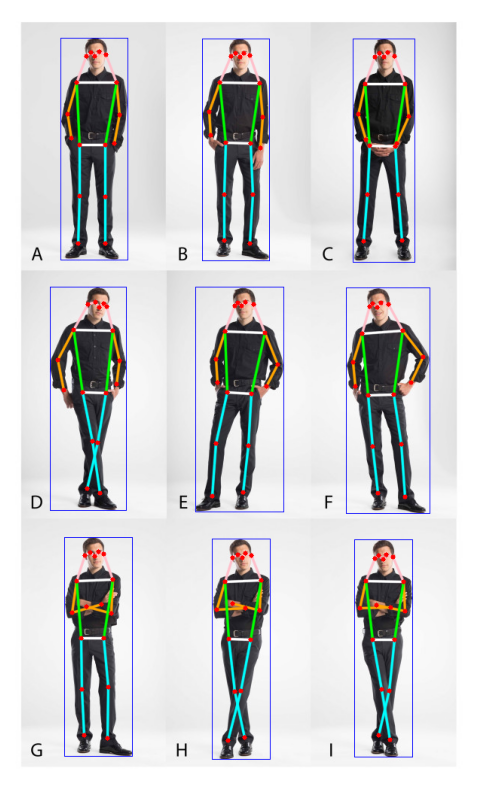

In [ ]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation

# --------------------------
# Config
# --------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = "datasets/excavators/Male-Posing.jpg"

# Skeleton definition
skeleton = [
    [0, 1], [0, 2],       # Nose to eyes
    [1, 3], [2, 4],       # Eyes to ears
    [3, 5], [4, 6],       # Ears to shoulders
    [5, 6],               # Shoulders
    [5, 7], [7, 9],       # Left Arm
    [6, 8], [8, 10],      # Right Arm
    [5, 11], [6, 12],     # Torso
    [11, 12],             # Hip
    [11, 13], [13, 15],   # Left Leg
    [12, 14], [14, 16],   # Right Leg
]

# Color mapping per edge group (BGR)
COLORS = {
    'face': (203, 192, 255),
    'shoulders': (255, 255, 255),
    'left_arm': (0, 165, 255),
    'right_arm': (0, 165, 255),
    'torso': (0, 255, 0),
    'hip': (255, 255, 255),
    'left_leg': (255, 255, 0),
    'right_leg': (255, 255, 0),
}

edge_to_group = {
    (0, 1): 'face', (0, 2): 'face', (1, 3): 'face', (2, 4): 'face',
    (3, 5): 'face', (4, 6): 'face',
    (5, 6): 'shoulders',
    (5, 7): 'left_arm', (7, 9): 'left_arm',
    (6, 8): 'right_arm', (8, 10): 'right_arm',
    (5, 11): 'torso', (6, 12): 'torso',
    (11, 12): 'hip',
    (11, 13): 'left_leg', (13, 15): 'left_leg',
    (12, 14): 'right_leg', (14, 16): 'right_leg',
}

# --------------------------
# Draw function
# --------------------------
def draw_keypoints_and_skeleton(img, bbox, keypoints, draw_bbox=True):
    if draw_bbox and bbox is not None:
        xmin, ymin, xmax, ymax = map(int, bbox)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 0, 0), 1)

    # Draw skeleton
    for edge in skeleton:
        start_idx, end_idx = edge
        if start_idx < len(keypoints) and end_idx < len(keypoints):
            pt1 = keypoints[start_idx]
            pt2 = keypoints[end_idx]
            if all(c > 0 for c in pt1) and all(c > 0 for c in pt2):
                group = edge_to_group.get((start_idx, end_idx), 'face')
                color = COLORS[group]
                cv2.line(img, (int(pt1[0]), int(pt1[1])),
                         (int(pt2[0]), int(pt2[1])), color, 2, lineType=cv2.LINE_AA)

    # Draw keypoints
    for x, y in keypoints:
        if x > 0 and y > 0:
            cv2.circle(img, (int(x), int(y)), 3, (0, 0, 255), -1)

# --------------------------
# Load image
# --------------------------
image = Image.open(image_path).convert("RGB")

# --------------------------
# Stage 1: Object detection
# --------------------------
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained(
    "PekingU/rtdetr_r50vd_coco_o365", device_map=device
)

inputs = person_image_processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]
person_boxes = result["boxes"][result["labels"] == 0].cpu().numpy()

# Convert to (x, y, w, h) format for ViTPose input
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0]
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1]

# --------------------------
# Stage 2: Pose estimation
# --------------------------
image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-base")
pose_model = VitPoseForPoseEstimation.from_pretrained(
    "usyd-community/vitpose-plus-base", device_map=device
)

inputs = image_processor(image, boxes=[person_boxes], return_tensors="pt").to(device)
inputs["dataset_index"] = torch.tensor([0], device=device)  # MOE: human = 0

with torch.no_grad():
    outputs = pose_model(**inputs)

pose_results = image_processor.post_process_pose_estimation(
    outputs, boxes=[person_boxes], threshold=0.1
)
image_pose_result = pose_results[0]

# --------------------------
# Draw results
# --------------------------
img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

for i, person_pose in enumerate(image_pose_result):
    bbox_xywh = person_boxes[i]
    bbox_xyxy = [
        bbox_xywh[0],
        bbox_xywh[1],
        bbox_xywh[0] + bbox_xywh[2],
        bbox_xywh[1] + bbox_xywh[3],
    ]
    keypoints = person_pose["keypoints"]
    draw_keypoints_and_skeleton(img_bgr, bbox_xyxy, keypoints, draw_bbox=True)

# Convert back to RGB for display
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

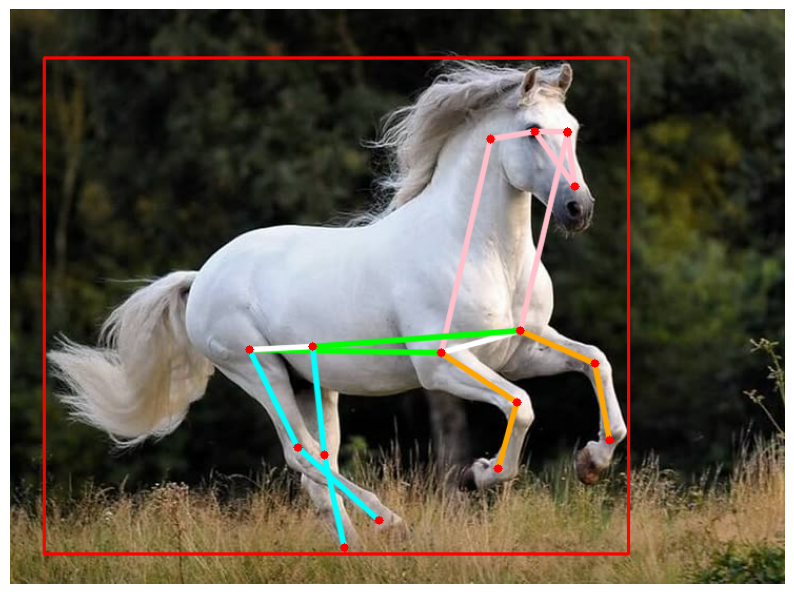

In [5]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation

# --------------------------
# Config
# --------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = "datasets/vitpose_models/white-horse.jpg"

# Skeleton definition
skeleton = [
    [0, 1], [0, 2],       # Nose to eyes
    [1, 2],               # Eyes to eyes
    [1, 3], [2, 4],       # Eyes to ears
    [3, 5], [4, 6],       # Ears to shoulders
    [5, 6],               # Shoulders
    [5, 7], [7, 9],       # Left Arm
    [6, 8], [8, 10],      # Right Arm
    [5, 11], [6, 12],     # Torso
    [11, 12],             # Hip
    [11, 13], [13, 15],   # Left Leg
    [12, 14], [14, 16],   # Right Leg
]

# Color mapping per edge group (BGR)
COLORS = {
    'face': (203, 192, 255),
    'shoulders': (255, 255, 255),
    'left_arm': (0, 165, 255),
    'right_arm': (0, 165, 255),
    'torso': (0, 255, 0),
    'hip': (255, 255, 255),
    'left_leg': (255, 255, 0),
    'right_leg': (255, 255, 0),
}

edge_to_group = {
    (0, 1): 'face', (0, 2): 'face', (1, 2): 'face', (1, 3): 'face', (2, 4): 'face',
    (3, 5): 'face', (4, 6): 'face',
    (5, 6): 'shoulders',
    (5, 7): 'left_arm', (7, 9): 'left_arm',
    (6, 8): 'right_arm', (8, 10): 'right_arm',
    (5, 11): 'torso', (6, 12): 'torso',
    (11, 12): 'hip',
    (11, 13): 'left_leg', (13, 15): 'left_leg',
    (12, 14): 'right_leg', (14, 16): 'right_leg',
}

# --------------------------
# Draw function
# --------------------------
def draw_keypoints_and_skeleton(img, bbox, keypoints, draw_bbox=True):
    if draw_bbox and bbox is not None:
        xmin, ymin, xmax, ymax = map(int, bbox)
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)

    # Draw skeleton
    for edge in skeleton:
        start_idx, end_idx = edge
        if start_idx < len(keypoints) and end_idx < len(keypoints):
            pt1 = keypoints[start_idx]
            pt2 = keypoints[end_idx]
            if all(c > 0 for c in pt1) and all(c > 0 for c in pt2):
                group = edge_to_group.get((start_idx, end_idx), 'face')
                color = COLORS[group]
                cv2.line(img, (int(pt1[0]), int(pt1[1])),
                         (int(pt2[0]), int(pt2[1])), color, 3, lineType=cv2.LINE_AA)

    # Draw keypoints
    for x, y in keypoints:
        if x > 0 and y > 0:
            cv2.circle(img, (int(x), int(y)), 4, (0, 0, 255), -1)

# Map COCO animal IDs to names
COCO_ANIMAL_IDS = {
    15: "cat",
    16: "dog",
    17: "horse",
    18: "sheep",
    19: "cow",
    20: "elephant",
    21: "bear",
    22: "zebra",
    23: "giraffe",
    14: "bird"
}

# Load image
image = Image.open(image_path).convert("RGB")

# Stage 1: Object detection (human + animals)
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained(
    "PekingU/rtdetr_r50vd_coco_o365", device_map=device
)
inputs = person_image_processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]

boxes_all = []
dataset_indices = []

for bbox, label_id in zip(result["boxes"], result["labels"]):
    label_id = int(label_id.item())

    # Human
    if label_id == 0:
        boxes_all.append(bbox.cpu().numpy())
        dataset_indices.append(0)  # human dataset

    # Animals in COCO
    elif label_id in COCO_ANIMAL_IDS:
        boxes_all.append(bbox.cpu().numpy())
        dataset_indices.append(2)  # AP-10K animal dataset

# Stop if no valid detections
if not boxes_all:
    print("No human or target animal detected.")
else:
    # Convert to np.array and xywh format for ViTPose
    boxes_all = np.array(boxes_all, dtype=np.float32)
    boxes_all[:, 2] = boxes_all[:, 2] - boxes_all[:, 0]
    boxes_all[:, 3] = boxes_all[:, 3] - boxes_all[:, 1]

    # Stage 2: Pose estimation
    image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-huge")
    pose_model = VitPoseForPoseEstimation.from_pretrained(
        "usyd-community/vitpose-plus-huge", device_map=device
    )

    inputs = image_processor(image, boxes=[boxes_all], return_tensors="pt").to(device)
    inputs["dataset_index"] = torch.tensor(dataset_indices, device=device)

    with torch.no_grad():
        outputs = pose_model(**inputs)

    pose_results = image_processor.post_process_pose_estimation(
        outputs, boxes=[boxes_all], threshold=0.1
    )
    image_pose_result = pose_results[0]

    # Draw
    img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    for i, pose in enumerate(image_pose_result):
        bbox_xywh = boxes_all[i]
        bbox_xyxy = [
            bbox_xywh[0],
            bbox_xywh[1],
            bbox_xywh[0] + bbox_xywh[2],
            bbox_xywh[1] + bbox_xywh[3],
        ]
        keypoints = pose["keypoints"]
        draw_keypoints_and_skeleton(img_bgr, bbox_xyxy, keypoints, draw_bbox=True)

    # Show
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

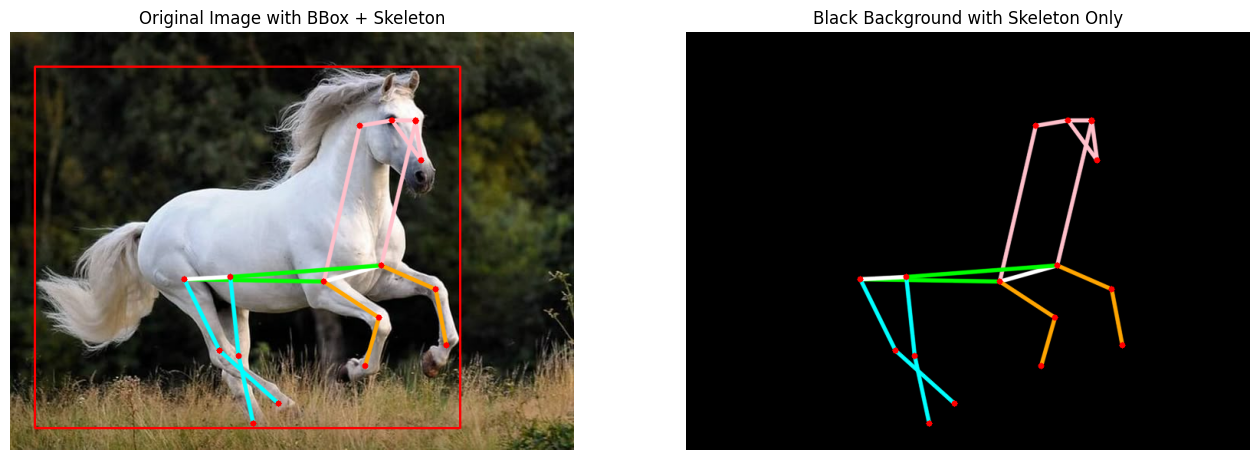

In [ ]:
# --------------------------
# Config
# --------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
image_path = "datasets/vitpose_models/white-horse.jpg"

# Load image
image = Image.open(image_path).convert("RGB")

# Stage 1: Object detection (human + animals)
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
person_model = RTDetrForObjectDetection.from_pretrained(
    "PekingU/rtdetr_r50vd_coco_o365", device_map=device
)
inputs = person_image_processor(images=image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = person_model(**inputs)

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
)
result = results[0]

boxes_all = []
dataset_indices = []

for bbox, label_id in zip(result["boxes"], result["labels"]):
    label_id = int(label_id.item())

    # Human
    if label_id == 0:
        boxes_all.append(bbox.cpu().numpy())
        dataset_indices.append(0)  # human dataset

    # Animals in COCO
    elif label_id in COCO_ANIMAL_IDS:
        boxes_all.append(bbox.cpu().numpy())
        dataset_indices.append(2)  # AP-10K animal dataset

# Stop if no valid detections
if not boxes_all:
    print("No human or target animal detected.")
else:
    # Convert to np.array and xywh format for ViTPose
    boxes_all = np.array(boxes_all, dtype=np.float32)
    boxes_all[:, 2] = boxes_all[:, 2] - boxes_all[:, 0]
    boxes_all[:, 3] = boxes_all[:, 3] - boxes_all[:, 1]

    # Stage 2: Pose estimation
    image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-huge")
    pose_model = VitPoseForPoseEstimation.from_pretrained(
        "usyd-community/vitpose-plus-huge", device_map=device
    )

    inputs = image_processor(image, boxes=[boxes_all], return_tensors="pt").to(device)
    inputs["dataset_index"] = torch.tensor(dataset_indices, device=device)

    with torch.no_grad():
        outputs = pose_model(**inputs)

    pose_results = image_processor.post_process_pose_estimation(
        outputs, boxes=[boxes_all], threshold=0.1
    )
    image_pose_result = pose_results[0]

    # Draw
    img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Prepare images:
    img_with_bbox = img_bgr.copy()
    img_skeleton_only = np.zeros_like(img_bgr)  # black image same size as original

    for i, pose in enumerate(image_pose_result):
        bbox_xywh = boxes_all[i]
        bbox_xyxy = [
            bbox_xywh[0],
            bbox_xywh[1],
            bbox_xywh[0] + bbox_xywh[2],
            bbox_xywh[1] + bbox_xywh[3],
        ]
        keypoints = pose["keypoints"]
        draw_keypoints_and_skeleton(img_with_bbox, bbox_xyxy, keypoints, draw_bbox=True)
        draw_keypoints_and_skeleton(img_skeleton_only, bbox_xyxy, keypoints, draw_bbox=False)

    # Show
    img_rgb = cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB)
    img_skeleton_only_rgb = cv2.cvtColor(img_skeleton_only, cv2.COLOR_BGR2RGB)

    # Plot side-by-side
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 2, 1)
    plt.title('Original Image with BBox + Skeleton')
    plt.axis('off')
    plt.imshow(img_rgb)

    plt.subplot(1, 2, 2)
    plt.title('Black Background with Skeleton Only')
    plt.axis('off')
    plt.imshow(img_skeleton_only_rgb)

    plt.show()

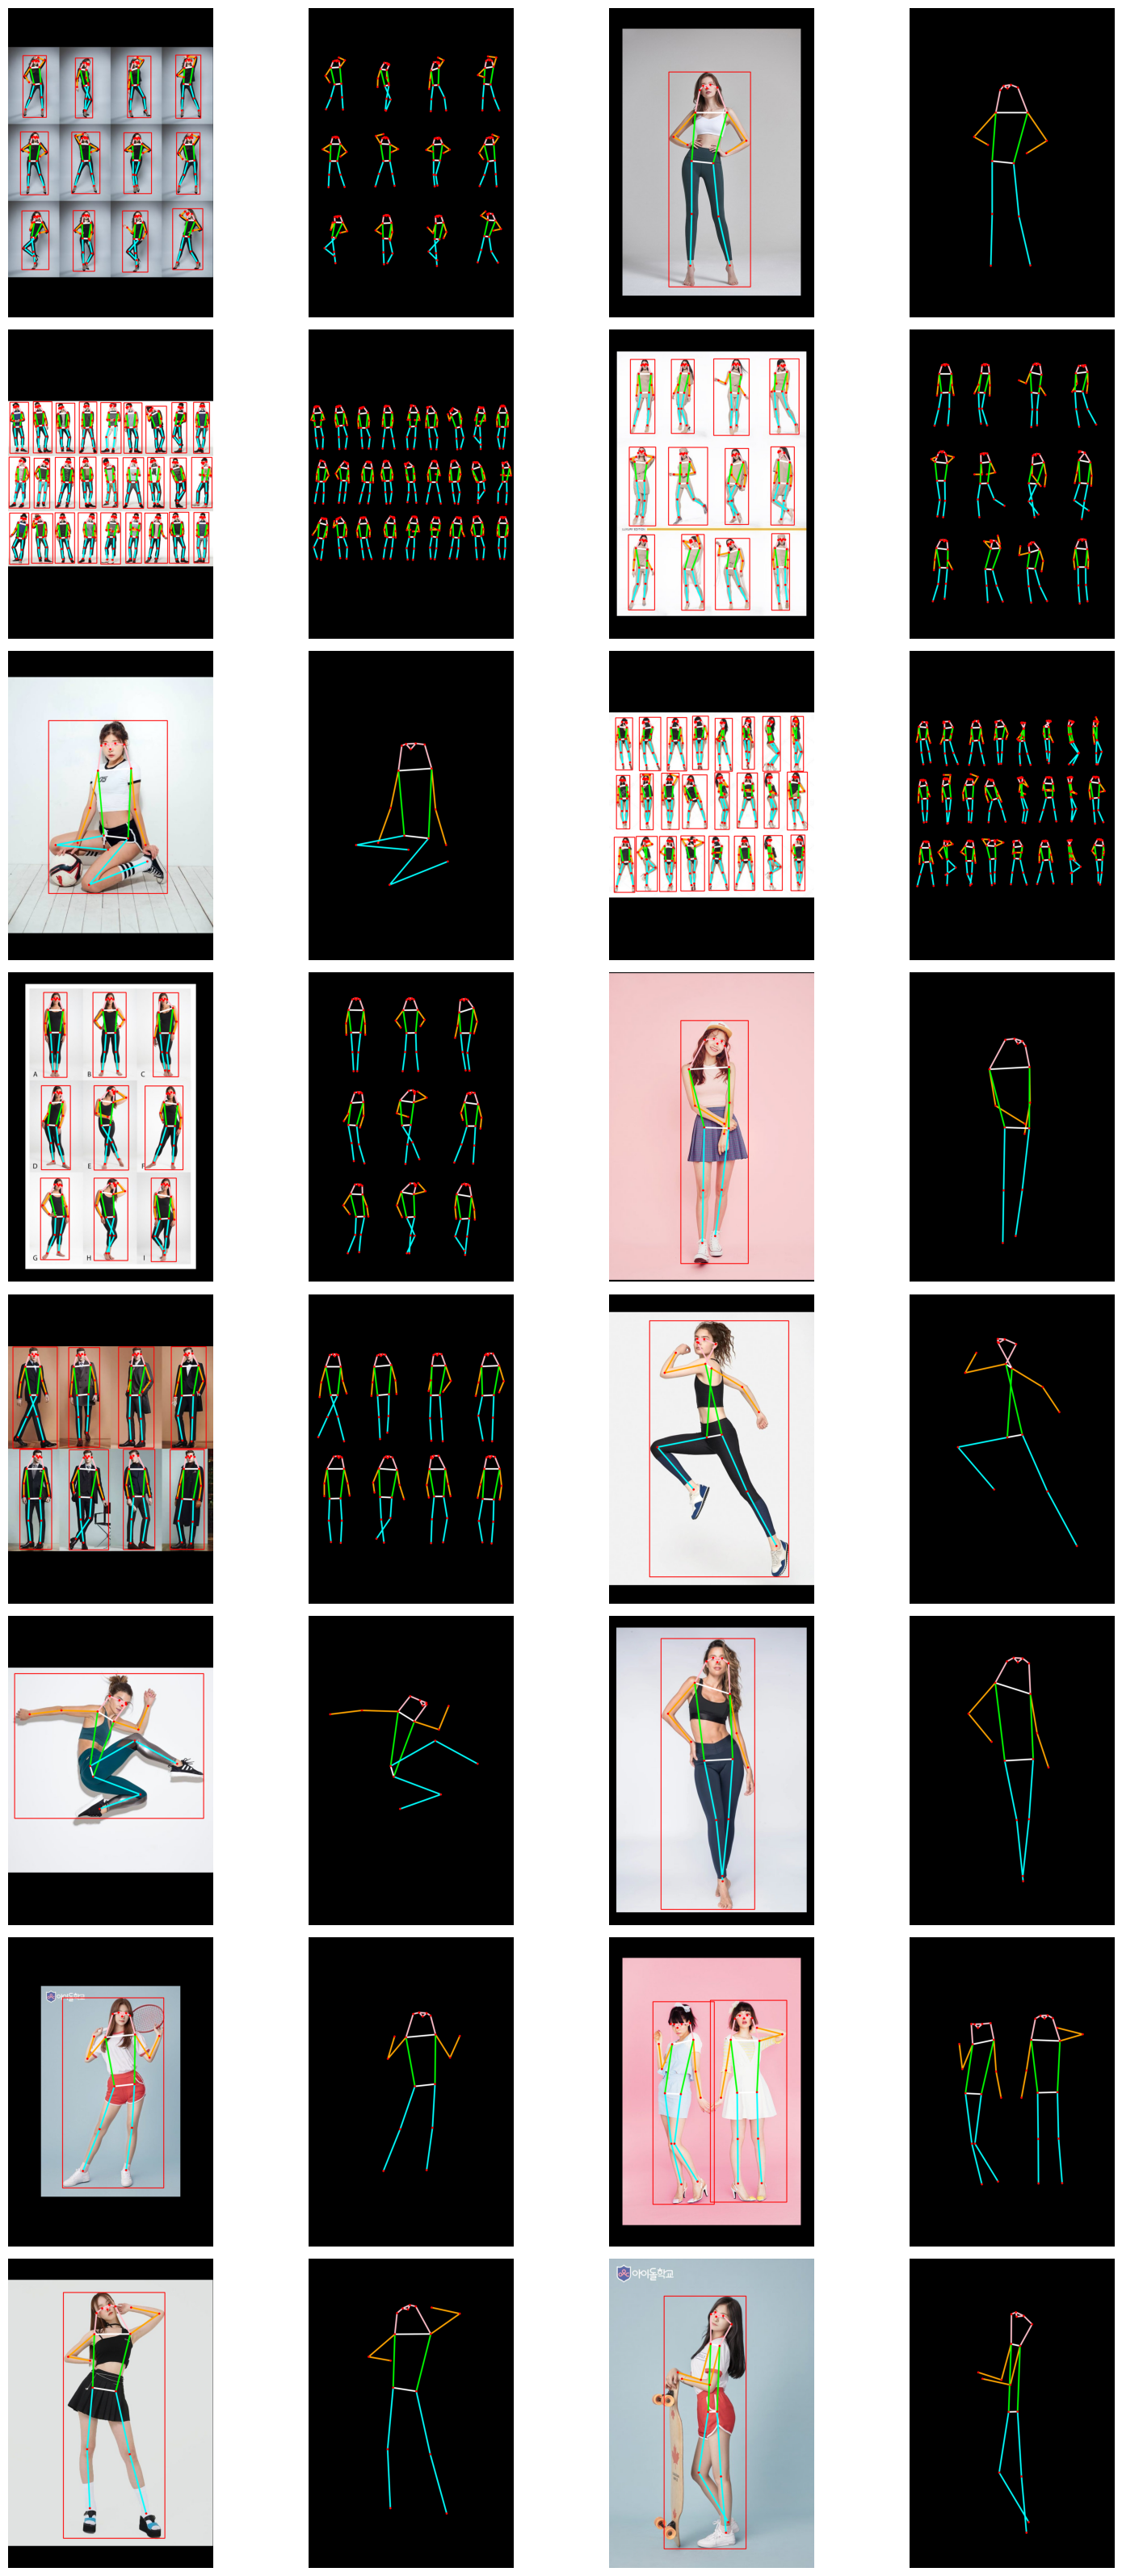

In [ ]:
import os
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# --------------------------
# Config
# --------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
val_dir = "/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests"
num_samples = 16

# --------------------------
# Collect images
# --------------------------
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))
img_paths = [os.path.join(val_dir, fname) for fname in selected_imgs]

processed_imgs = []
img_sizes = []

for image_path in img_paths:
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Stage 1: Object detection (human + animals)
    person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
    person_model = RTDetrForObjectDetection.from_pretrained(
        "PekingU/rtdetr_r50vd_coco_o365", device_map=device
    )
    inputs = person_image_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = person_model(**inputs)

    results = person_image_processor.post_process_object_detection(
        outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
    )
    result = results[0]

    boxes_all = []
    dataset_indices = []

    for bbox, label_id in zip(result["boxes"], result["labels"]):
        label_id = int(label_id.item())

        # Human
        if label_id == 0:
            boxes_all.append(bbox.cpu().numpy())
            dataset_indices.append(0)  # human dataset

        # Animals in COCO
        elif label_id in COCO_ANIMAL_IDS:
            boxes_all.append(bbox.cpu().numpy())
            dataset_indices.append(2)  # AP-10K animal dataset

    # Stop if no valid detections
    if not boxes_all:
        print(f"No human or target animal detected in {image_path}")
        continue

    # Convert to np.array and xywh format for ViTPose
    boxes_all = np.array(boxes_all, dtype=np.float32)
    boxes_all[:, 2] = boxes_all[:, 2] - boxes_all[:, 0]
    boxes_all[:, 3] = boxes_all[:, 3] - boxes_all[:, 1]

    # Stage 2: Pose estimation
    image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-huge")
    pose_model = VitPoseForPoseEstimation.from_pretrained(
        "usyd-community/vitpose-plus-huge", device_map=device
    )

    inputs = image_processor(image, boxes=[boxes_all], return_tensors="pt").to(device)
    inputs["dataset_index"] = torch.tensor(dataset_indices, device=device)

    with torch.no_grad():
        outputs = pose_model(**inputs)

    pose_results = image_processor.post_process_pose_estimation(
        outputs, boxes=[boxes_all], threshold=0.1
    )
    image_pose_result = pose_results[0]

    # Draw
    img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Prepare images:
    img_with_bbox = img_bgr.copy()
    img_skeleton_only = np.zeros_like(img_bgr)  # black image same size as original

    for i, pose in enumerate(image_pose_result):
        bbox_xywh = boxes_all[i]
        bbox_xyxy = [
            bbox_xywh[0],
            bbox_xywh[1],
            bbox_xywh[0] + bbox_xywh[2],
            bbox_xywh[1] + bbox_xywh[3],
        ]
        keypoints = pose["keypoints"]
        draw_keypoints_and_skeleton(img_with_bbox, bbox_xyxy, keypoints, draw_bbox=True)
        draw_keypoints_and_skeleton(img_skeleton_only, bbox_xyxy, keypoints, draw_bbox=False)

    # Convert to RGB for matplotlib
    img_with_bbox_rgb = cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB)
    img_skeleton_only_rgb = cv2.cvtColor(img_skeleton_only, cv2.COLOR_BGR2RGB)

    processed_imgs.append((img_with_bbox_rgb, img_skeleton_only_rgb))
    img_sizes.append(img_bgr.shape[:2])  # (height, width)

# --------------------------
# Prepare for grid plot
# --------------------------
max_height = max(h for h, w in img_sizes)
max_width = max(w for h, w in img_sizes)

cols = 4  # 2 images x 2 visuals = 4 subplots per row
rows = (len(processed_imgs) + 1) // 2  # 2 images per row

plt.figure(figsize=(4 * cols, 4 * rows))

for idx, (img1, img2) in enumerate(processed_imgs):
    for view_idx, view in enumerate([img1, img2]):
        h, w = view.shape[:2]
        top = (max_height - h) // 2
        bottom = max_height - h - top
        left = (max_width - w) // 2
        right = max_width - w - left
        padded = cv2.copyMakeBorder(view, top, bottom, left, right, borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

        plot_idx = idx * 2 + view_idx + 1
        plt.subplot(rows, cols, plot_idx)
        plt.imshow(padded)
        plt.axis('off')

plt.tight_layout()
plt.show()

In [49]:
import os
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# --------------------------
# Config
# --------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
val_dir = "datasets/vitpose_models"
num_samples = 20

# Map COCO animal IDs to names
COCO_ANIMAL_IDS = {
    15: "cat",
    16: "dog",
    17: "horse",
    18: "sheep",
    19: "cow",
    20: "elephant",
    21: "bear",
    22: "zebra",
    23: "giraffe",
    14: "bird"
}

# --------------------------
# Collect images
# --------------------------
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))
img_paths = [os.path.join(val_dir, fname) for fname in selected_imgs]

processed_imgs = []
img_sizes = []

for image_path in img_paths:
    # Load image
    image = Image.open(image_path).convert("RGB")

    # Stage 1: Object detection (human + animals)
    person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365")
    person_model = RTDetrForObjectDetection.from_pretrained(
        "PekingU/rtdetr_r50vd_coco_o365", device_map=device
    )
    inputs = person_image_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = person_model(**inputs)

    results = person_image_processor.post_process_object_detection(
        outputs, target_sizes=torch.tensor([(image.height, image.width)]), threshold=0.3
    )
    result = results[0]

    boxes_all = []
    dataset_indices = []

    for bbox, label_id in zip(result["boxes"], result["labels"]):
        label_id = int(label_id.item())

        # Human
        if label_id == 0:
            boxes_all.append(bbox.cpu().numpy())
            dataset_indices.append(0)  # human dataset

        # Animals in COCO
        elif label_id in COCO_ANIMAL_IDS:
            boxes_all.append(bbox.cpu().numpy())
            dataset_indices.append(2)  # AP-10K animal dataset

    # Stop if no valid detections
    if not boxes_all:
        print(f"No human or target animal detected in {image_path}")
        continue

    # Convert to np.array and xywh format for ViTPose
    boxes_all = np.array(boxes_all, dtype=np.float32)
    boxes_all[:, 2] = boxes_all[:, 2] - boxes_all[:, 0]
    boxes_all[:, 3] = boxes_all[:, 3] - boxes_all[:, 1]

    # Stage 2: Pose estimation
    image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-plus-huge")
    pose_model = VitPoseForPoseEstimation.from_pretrained(
        "usyd-community/vitpose-plus-huge", device_map=device
    )

    inputs = image_processor(image, boxes=[boxes_all], return_tensors="pt").to(device)
    inputs["dataset_index"] = torch.tensor(dataset_indices, device=device)

    with torch.no_grad():
        outputs = pose_model(**inputs)

    pose_results = image_processor.post_process_pose_estimation(
        outputs, boxes=[boxes_all], threshold=0.1
    )
    image_pose_result = pose_results[0]

    # Draw
    img_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Prepare images:
    img_with_bbox = img_bgr.copy()
    img_skeleton_only = np.zeros_like(img_bgr)  # black image same size as original

    for i, pose in enumerate(image_pose_result):
        bbox_xywh = boxes_all[i]
        bbox_xyxy = [
            bbox_xywh[0],
            bbox_xywh[1],
            bbox_xywh[0] + bbox_xywh[2],
            bbox_xywh[1] + bbox_xywh[3],
        ]
        keypoints = pose["keypoints"]
        draw_keypoints_and_skeleton(img_with_bbox, bbox_xyxy, keypoints, draw_bbox=True)
        draw_keypoints_and_skeleton(img_skeleton_only, bbox_xyxy, keypoints, draw_bbox=False)

    # Convert to RGB for matplotlib
    img_with_bbox_rgb = cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB)
    img_skeleton_only_rgb = cv2.cvtColor(img_skeleton_only, cv2.COLOR_BGR2RGB)

    processed_imgs.append((img_with_bbox_rgb, img_skeleton_only_rgb))
    img_sizes.append(img_bgr.shape[:2])  # (height, width)

# --------------------------
# Prepare for grid plot
# --------------------------

cols = 4  # 2 images x 2 visuals = 4 subplots per row
rows = (len(processed_imgs) + 1) // 2  # 2 images per row

plt.figure(figsize=(4 * cols, 3 * rows))

# Target display size for each grid cell
target_height = 720
target_width = 1080

for idx, (img1, img2) in enumerate(processed_imgs):
    for view_idx, view in enumerate([img1, img2]):
        h, w = view.shape[:2]

        # Scale keeping aspect ratio
        scale = min(target_width / w, target_height / h)
        new_w, new_h = int(w * scale), int(h * scale)
        resized = cv2.resize(view, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

        # Pad to target size
        top = (target_height - new_h) // 2
        bottom = target_height - new_h - top
        left = (target_width - new_w) // 2
        right = target_width - new_w - left
        padded = cv2.copyMakeBorder(resized, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

        plot_idx = idx * 2 + view_idx + 1
        plt.subplot(rows, cols, plot_idx)
        plt.imshow(padded)
        plt.axis('off')

plt.tight_layout(pad=0)           # removes padding around the whole figure
plt.subplots_adjust(wspace=0, hspace=0)  # removes spacing between cells
plt.show()

Output hidden; open in https://colab.research.google.com to view.